In [5]:
import pandas as pd
#load wiki data with summary for KC
kc_wiki_with_summary = pd.read_csv('../../data/data_wiki_clustering/kc_wiki_with_summary.csv')
kc_wiki_with_summary
#preprocess
#reference for gensim library https://www.kaggle.com/code/venkatkrishnan/gensim-text-mining-techniques
#https://radimrehurek.com/gensim/parsing/preprocessing.html
#pd.set_option('display.max_colwidth', 1)
import gensim
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, strip_punctuation, remove_stopwords, strip_short
transform_to_lower = lambda s: s.lower()
filters = [strip_tags,
           strip_numeric,
          transform_to_lower,
          strip_punctuation,
          strip_multiple_whitespaces,
          remove_stopwords,
          strip_short
          ]

def cleaning_text(document):
    clean_text = preprocess_string(document, filters)
    return clean_text

kc_wiki_with_summary['clean_summary'] = kc_wiki_with_summary['page_summary'].apply(cleaning_text)

TypeError: 'str' object is not callable

In [3]:
from shapely.geometry import MultiPoint
#load data
kc_coords = kc_wiki_with_summary[['gt_lon', 'gt_lat']].to_numpy()
#finding the optimum epsilon
import numpy as np
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(kc_coords)
distances, indices = neighbors_fit.kneighbors(kc_coords)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.xlabel('Objects with a nearest neighbour within epsilon', fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.plot(distances)

NameError: name 'kc_wiki_with_summary' is not defined

In [3]:
#run dbscan
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
#run dbscan clustering
dbscan = DBSCAN(eps=0.0020, min_samples=5)
kc_dbscan = dbscan.fit(kc_coords)
#get the labels of clustering
dbscan_labels = kc_dbscan.labels_
dbscan_labels
print('no. of clusters:', len(np.unique(dbscan_labels)))
print('no of noise:', np.sum(np.array(dbscan_labels) == -1, axis=0))
#add cluster labels to dataset
kc_wiki_with_summary['cluster'] = dbscan_labels

no. of clusters: 15
no of noise: 130


[<POLYGON ((-0.184 51.499, -0.19 51.499, -0.194 51.501, -0.193 51.503, -0.193...>, <POLYGON ((-0.172 51.488, -0.175 51.488, -0.175 51.488, -0.175 51.489, -0.17...>, <POLYGON ((-0.182 51.492, -0.184 51.493, -0.183 51.495, -0.183 51.495, -0.18...>, <POLYGON ((-0.165 51.486, -0.17 51.487, -0.168 51.488, -0.165 51.49, -0.164 ...>, <POLYGON ((-0.178 51.485, -0.179 51.485, -0.18 51.486, -0.181 51.488, -0.181...>, <POLYGON ((-0.161 51.495, -0.16 51.497, -0.159 51.499, -0.159 51.499, -0.158...>, <POLYGON ((-0.173 51.482, -0.175 51.483, -0.175 51.484, -0.174 51.486, -0.17...>, <POLYGON ((-0.163 51.484, -0.166 51.484, -0.164 51.484, -0.163 51.484, -0.16...>, <POLYGON ((-0.173 51.496, -0.174 51.496, -0.176 51.498, -0.17 51.497, -0.173...>, <POLYGON ((-0.168 51.494, -0.169 51.495, -0.169 51.496, -0.167 51.497, -0.16...>, <POLYGON ((-0.172 51.492, -0.174 51.492, -0.172 51.493, -0.172 51.493, -0.17...>, <POLYGON ((-0.162 51.493, -0.164 51.494, -0.162 51.496, -0.162 51.493))>, <POLYGON ((-0.162 51.48

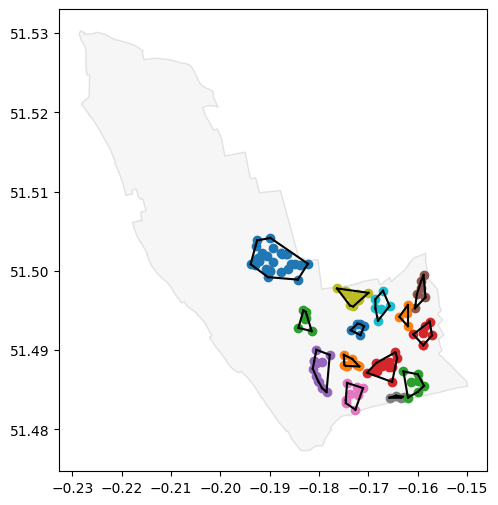

In [4]:
#Regionalise
#create convex hull
#Reference https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html
import scipy
import numpy
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt

#remove noise
remove = kc_wiki_with_summary[kc_wiki_with_summary['cluster'] == -1].index
kc_wiki_with_summary = kc_wiki_with_summary.drop(remove)
#select only necessary column
db_cl = kc_wiki_with_summary[["gt_lon",
                   "gt_lat",
                   "cluster"]]

import geopandas as gpd
#load boundary file for kc
kc_boundary = gpd.read_file('../../data/boundary_london/kc.shp')
# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
kc_boundary.to_crs(epsg=4326).plot(ax=ax,
                                  color= 'lightgrey', alpha= 0.2,
                                  edgecolor = '0.5')
#run convexhull for each clusters seperately
#create a list of convex hull
h = [] #for list of polygon coordinates from chull
for i in range(0,14):
    cluster_i = db_cl.loc[db_cl['cluster']==i]
    db_cl_i = cluster_i[["gt_lon", "gt_lat"]].to_numpy()
    ch_i = ConvexHull(db_cl_i)
    h.append(db_cl_i[ch_i.vertices,:].tolist())
    plt.plot(db_cl_i[:, 0],db_cl_i[:, 1],  'o')
    for simplex in ch_i.simplices:
        ploted=plt.plot(db_cl_i[simplex, 0], db_cl_i[simplex, 1],'k-')
#for generating polygon from ordered manner
#Ref: https://stackoverflow.com/questions/61740032/how-to-convert-convex-hull-vertices-into-a-geopandas-polygon
from shapely.geometry import MultiPoint
c_h = []
for hull in h:
    c_h.append(MultiPoint(hull).convex_hull)

print(c_h)

In [35]:
#group wikipedia summary by cluster
from itertools import chain
kc_wiki_with_summary_dbscan = kc_wiki_with_summary.groupby('cluster', as_index = False)['clean_summary'].agg(lambda x: list(chain.from_iterable(x)))
data_dbscan = pd.DataFrame(kc_wiki_with_summary_dbscan, columns =('cluster', 'clean_summary'))
tag_list_dbscan = data_dbscan.clean_summary.values.tolist()

In [36]:
data_dbscan.to_csv('../../data/data_wiki_clustering/kc_wiki_dbscan_tag_oct.csv')

In [5]:
#Bring BTM topic distribution run on R
##calling the saved  data from the folder
#load wiki data for KC
kc_wiki_topic_df = pd.read_csv('../../data/data_wiki_clustering/wiki_kc_btm_oct.csv')

In [6]:
##add c_h polygon coordinates
kc_wiki_topic_df['geometry'] = c_h
#set index as column
kc_wiki_topic_df['cluster'] = kc_wiki_topic_df.index

In [7]:
kc_wiki_topic_df

,Unnamed: 0,V1,V2,V3,V4,V5,V6,Topic,cluster,geometry
0,0,0.001326,0.100070,0.255631,0.082531,0.081582,0.478859,V6,0,"POLYGON ((-0.18432 51.498891, -0.19036667 51.4..."
1,1,0.000707,0.155555,0.022369,0.235184,0.201437,0.384750,V6,1,"POLYGON ((-0.17186667 51.48793333, -0.1746 51...."
2,2,0.001076,0.010053,0.120656,0.133793,0.043180,0.691242,V6,2,"POLYGON ((-0.18150556 51.49239167, -0.1842 51...."
3,3,0.000941,0.013160,0.021667,0.226830,0.338704,0.398697,V6,3,"POLYGON ((-0.1652 51.48597, -0.17029 51.48715,..."
4,4,0.000402,0.145352,0.107443,0.183692,0.021674,0.541436,V6,4,"POLYGON ((-0.1785 51.4847, -0.1794 51.4852, -0..."
5,5,0.001257,0.025232,0.298086,0.019513,0.054952,0.600960,V6,5,"POLYGON ((-0.16055556 51.49527778, -0.16019 51..."
6,6,0.000529,0.129779,0.019525,0.146336,0.387329,0.316500,V5,6,"POLYGON ((-0.17264444 51.48248333, -0.17458889..."
7,7,0.000572,0.023816,0.017814,0.162976,0.714170,0.080651,V5,7,"POLYGON ((-0.16343 51.48398, -0.16573 51.48399..."
8,8,0.000867,0.190678,0.621179,0.109329,0.021142,0.056804,V3,8,"POLYGON ((-0.1731 51.4955, -0.17376 51.49563, ..."
9,9,0.001835,0.011766,0.011016,0.361602,0.050764,0.563017,V6,9,"POLYGON ((-0.168067 51.493696, -0.16859167 51...."


In [8]:
#add topic labels
#Name the lda topics
def get_btm_topic_name(topic):
    if topic == 'V2':
        return 'Residential area'
    elif topic == 'V3':
        return 'Museum and Exhibition'
    elif topic == 'V5':
        return 'Notable Houses, Square, Gardens'
    else:
        return 'Notable Roads and Streets'
kc_wiki_topic_df['BTM_topic_wiki'] = kc_wiki_topic_df['Topic'].apply(get_btm_topic_name)

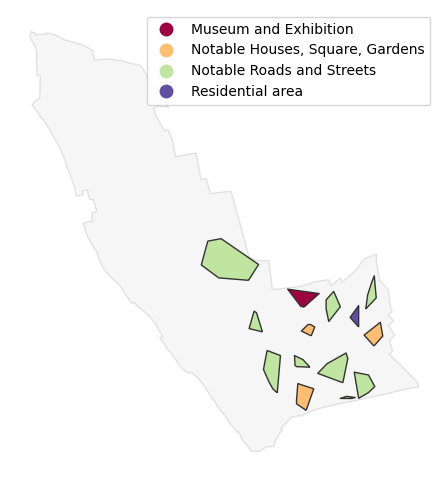

In [9]:
#Mapping
import geopandas as gpd
btm_cluster_gdf = gpd.GeoDataFrame(kc_wiki_topic_df, geometry="geometry", crs='EPSG:4326')
#load boundary file for kc
kc_boundary = gpd.read_file('../../data/boundary_london/kc.shp')
# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
kc_boundary.to_crs(epsg=4326).plot(ax=ax,
                                  color= 'lightgrey', alpha= 0.2,
                                  edgecolor = '0.5')
map = btm_cluster_gdf.plot(column='BTM_topic_wiki', 
                      categorical = True, 
                      edgecolor='0.2',
                      cmap='Spectral', 
                      ax=ax, 
                      legend = True) 
                    
                          
#map.legend(['BTM_topic_wiki'], loc='upper right')
ax.set_axis_off()
map_k = '../../docs/docs_wiki_clustering/kc_wiki_btm_maoct.png'
plt.savefig(map_k)
#Add label
#Referred from https://stackoverflow.com/questions/68832737/how-to-add-both-name-and-number-description-on-geo-pandas-plot-in-python
#btm_kcluster_gdf.apply(lambda x: ax.annotate(text=x.Topic, 
                                             #xy=x.geometry.centroid.coords[0], 
                                             #ha='center',
                                             #color = "black"), axis=1)
#ax.set_title('k-means cluster of OSM tags in Kensington and Chelsea',fontsize=20)

In [10]:
btm_cluster_gdf.to_csv('../../data/data_wiki_clustering/wiki_kc_btm_topics.csv')

In [4]:
#POI based topic arrangement
import pandas as pd
btm_topics_wiki_kc = pd.read_csv('../../data/data_wiki_clustering/wiki_kc_btm_topics.csv')

TypeError: 'str' object is not callable

In [ ]:
kc_btm_wiki_poi = pd.merge (kc_osm_data3, btm_topics_wiki_kc, on = 'cluster')

In [5]:
import pandas as pd
#load wiki data with summary for KC
kc_wiki_with_summary = pd.read_csv('../../data/data_wiki_clustering/kc_wiki_with_summary.csv')

TypeError: 'str' object is not callable